<a href="https://colab.research.google.com/github/Valerie-Osawe/Analysis_on_ABtest_dataset/blob/main/A_B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Data source is from **Kaggle**.

- The data can be found [here](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?resource=download)

__Data dictionary__
```
- Index: Row index
- user id: User ID (unique)
- test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- converted: If a person bought the product then True, else is False
- total ads: Amount of ads seen by person
- most ads day: Day that the person saw the biggest amount of ads
- most ads hour: Hour of day that the person saw the biggest amount of ads
```
__Objectives__
```
- Analyze the groups
- Find if the ads were successful
- Check the difference between the groups is statistically significant.

```

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind

import random

In [3]:
# Load the data
market = pd.read_csv('marketing_AB.csv')
market.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Basic Exploration

In [4]:
# Check the size of the data
market.shape

(588101, 7)

In [5]:
# Check the data information
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


From the above there are no null values.

In [6]:
# Check for duplicates
market.duplicated().sum()

0

In [7]:
market.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [8]:
# Check the Unnamed: 0 column
market['Unnamed: 0'].sample(20)

458144    458144
393976    393976
566659    566659
181566    181566
239937    239937
57075      57075
585584    585584
285524    285524
518252    518252
36774      36774
233679    233679
42601      42601
240896    240896
88585      88585
193440    193440
558478    558478
578030    578030
418708    418708
124934    124934
60564      60564
Name: Unnamed: 0, dtype: int64

From the above it can be concluded that the Unnamed: 0 column is an index row column. Therefore the column will be dropped

In [9]:
# Drop the Unnamed: 0 column
market.drop('Unnamed: 0', axis = 1, inplace = True)

## Data Exploration

#### How many percent of the test group saw an ad

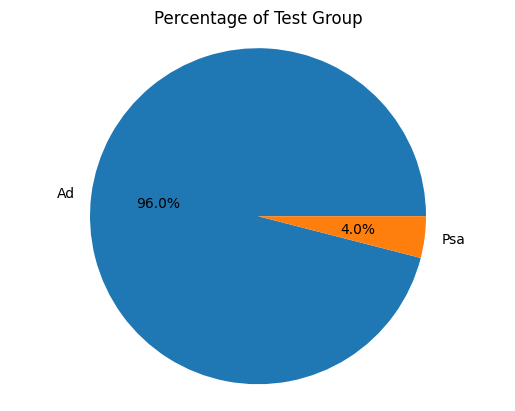

In [10]:
labels = ['Ad', 'Psa']
values = market['test group'].value_counts()

# Plotting the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')
# Title
plt.title('Percentage of Test Group')
# Aspect ratio
plt.axis('equal')
# Display the chart
plt.show()

From the above, 96% of the test group saw an Ad, while 4% saw a public service announcement.

#### How many percent of the test group bought the product

In [11]:
market.groupby('test group')['converted'].value_counts()

test group  converted
ad          False        550154
            True          14423
psa         False         23104
            True            420
Name: converted, dtype: int64

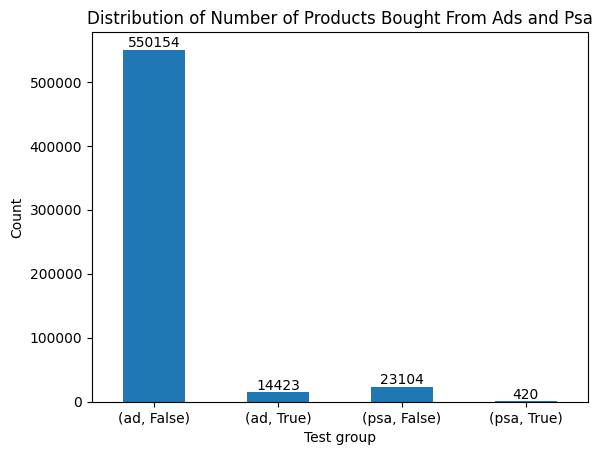

In [12]:
group = market.groupby('test group')['converted'].value_counts()


def plot_bar_chart_with_annotations(group):
    # Plot the chart
    ax = group.plot.bar()

    # Add annotations to the bars
    for i, v in enumerate(group):
        ax.text(i, v, str(v), ha='center', va='bottom')

    # Set labels and title
    plt.xlabel('Test group')
    plt.ylabel('Count')
    plt.title('Distribution of Number of Products Bought From Ads and Psa')

    # Rotate x-axis tick labels to 180 degrees
    plt.xticks(rotation=0)

    # Show the chart
    plt.show()

# Call the function
plot_bar_chart_with_annotations(group)

From the above plot it can be seen that 14423 persons bought a product after seeing an Ad while 420 persons bought a product after seeing a Psa.

## At what time and day were the ads most seen?

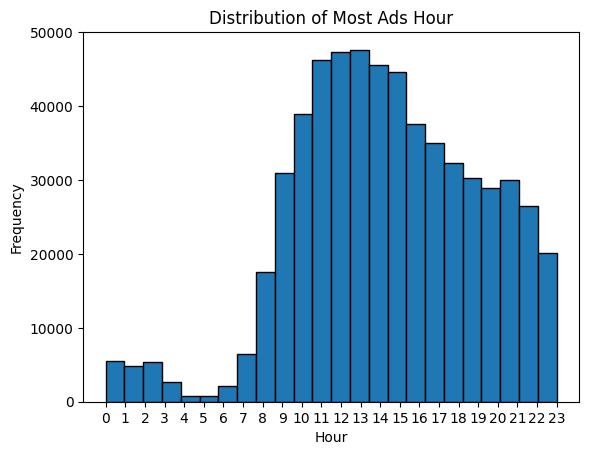

In [28]:
plt.hist(market['most ads hour'], bins=24, edgecolor='black')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Distribution of Most Ads Hour')
plt.xticks(range(24))  # Set x-axis ticks to show hours from 0 to 23
plt.show()

It can be seen that the hour the most ads were seen by a person were between 11pm and 3pm.

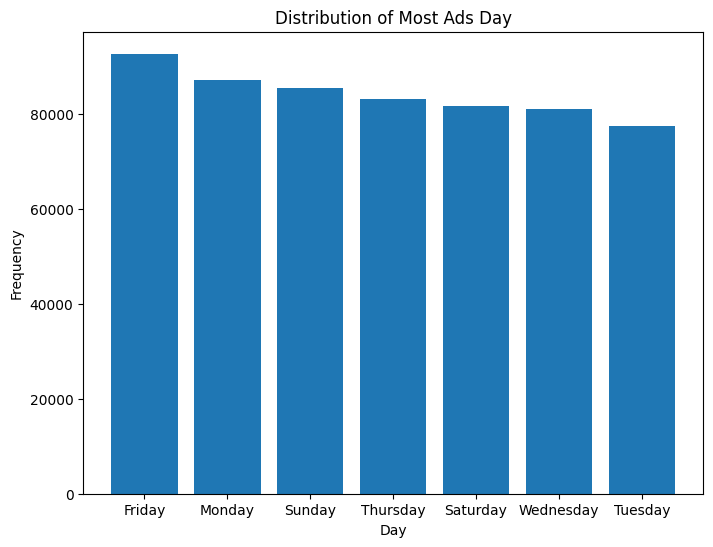

In [41]:
# Select the days the ads were seen
day = market['most ads day'].value_counts()

# Plot a bar chart
plt.figure(figsize= (8,6))
plt.bar(day.index, day.values)
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Distribution of Most Ads Day')
plt.show()

It can be seen that most ads were seen on Fridays and the least was seen on Tuesdays

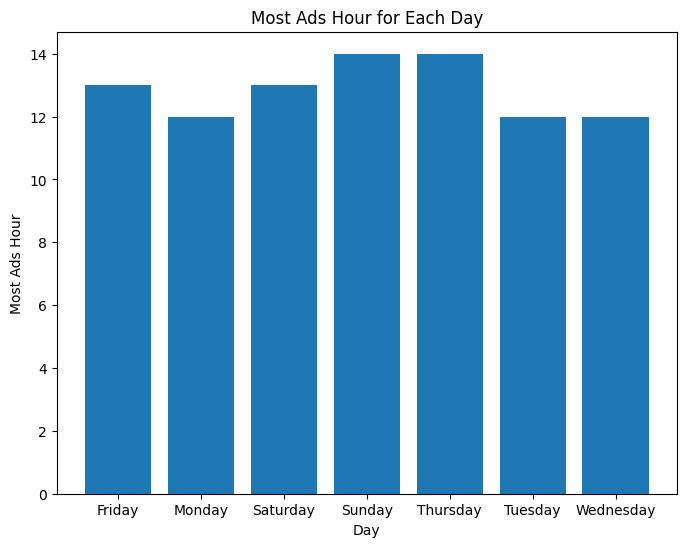

In [46]:
# Group the data by 'most ads day' and find the mode (most frequent hour) for each day
most_ads_hour_per_day = market.groupby('most ads day')['most ads hour'].agg(lambda x: x.mode().iloc[0])
# Create a bar plot
plt.figure(figsize= (8,6))
plt.bar(most_ads_hour_per_day.index, most_ads_hour_per_day.values)

# Add labels and title
plt.xlabel('Day')
plt.ylabel('Most Ads Hour')
plt.title('Most Ads Hour for Each Day')

# Show the plot
plt.show()

From the above it can be seen that each day, most ads were seen in the afternoon.
- Monday's most ads were seen by 12pm
- Tuesday's most ads were seen by 12pm
- Wednesday's most ads were was seen by 12pm
- Thursday's most ads were seen by 2pm
- Friday's most ads were seen by 1pm
- Saturday's most ads were seen by 1pm
- Sunday's most ads were seen by 2pm

## Distribution of the number of Ads seen by a person

In [15]:
import matplotlib.pyplot as plt

def plot_histograms_by_range(data, range1, range2, title1, title2):
    # Create masks to filter data within each range
    mask_range1 = (data >= range1[0]) & (data <= range1[1])
    mask_range2 = (data >= range2[0]) & (data <= range2[1])

    # Create two separate subplots for each range
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot histogram for range 1 in the first subplot
    ax1.hist(data[mask_range1], bins=30, color='blue', alpha=0.7)
    ax1.set_xlabel('Total Ads seen by a person')
    ax1.set_ylabel('Frequency')
    ax1.set_title(title1)

    # Plot histogram for range 2 in the second subplot
    ax2.hist(data[mask_range2], bins=30, color='green', alpha=0.7)
    ax2.set_xlabel('Total Ads seen by a person')
    ax2.set_ylabel('Frequency')
    ax2.set_title(title2)

    # Adjust the layout to avoid overlapping titles
    plt.tight_layout()
    plt.show()


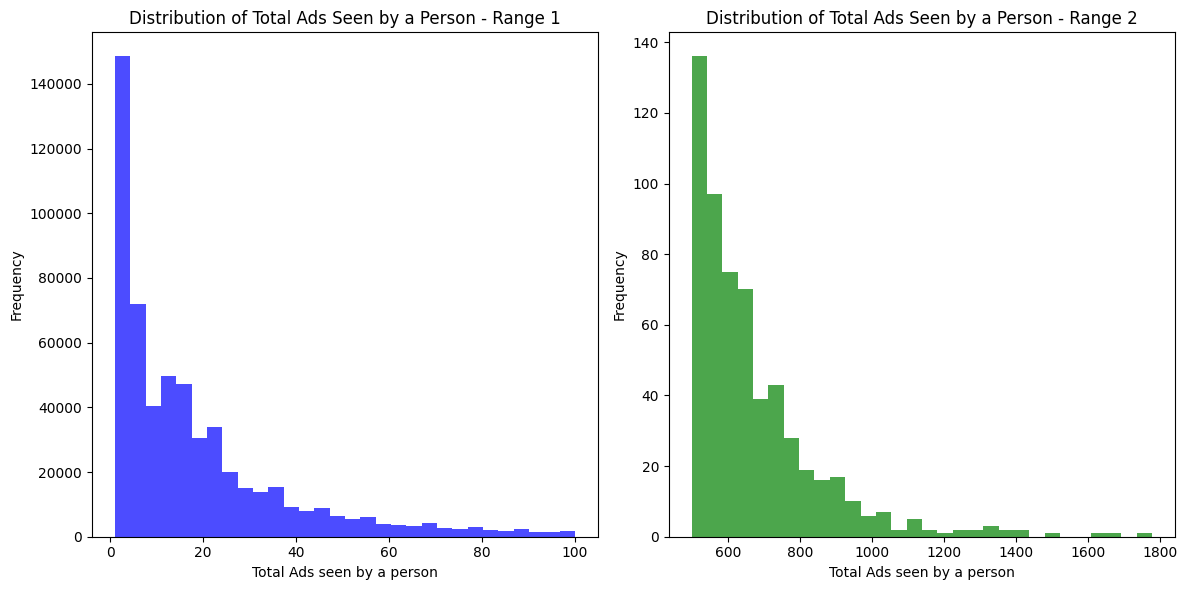

In [16]:
plot = market['total ads']

# Define the two ranges of interest and titles for the subplots
range1 = (0, 100)
range2 = (500, 2000)
title1 = "Distribution of Total Ads Seen by a Person - Range 1"
title2 = "Distribution of Total Ads Seen by a Person - Range 2"
# Call the function to plot the histograms
plot_histograms_by_range(plot, range1, range2, title1, title2)

## How many times did the people that bought a product see an ad?

In [17]:
# Check for the average number of times people that bought a product saw an ad
market.query("converted == True")['total ads'].mean()

83.88775853937884

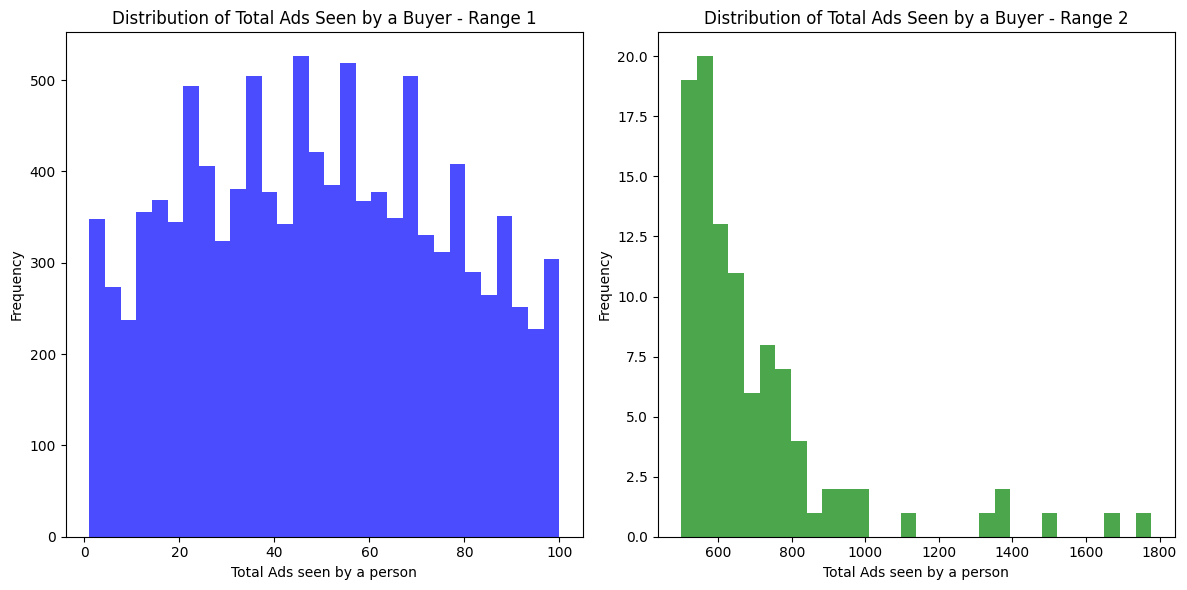

In [18]:
total_ads = market.query("converted == True")['total ads']
# Define the two ranges of interest and titles for the subplots
range1 = (0, 100)
range2 = (500, 2000)
title1 = "Distribution of Total Ads Seen by a Buyer - Range 1"
title2 = "Distribution of Total Ads Seen by a Buyer - Range 2"
# Call the function to plot the histograms
plot_histograms_by_range(total_ads, range1, range2, title1, title2)

It can be seen from the plot majority of the people that bought a product saw the ads more over 40 times.

In [19]:
market.query("converted == False")['total ads'].mean()

23.291495277867906

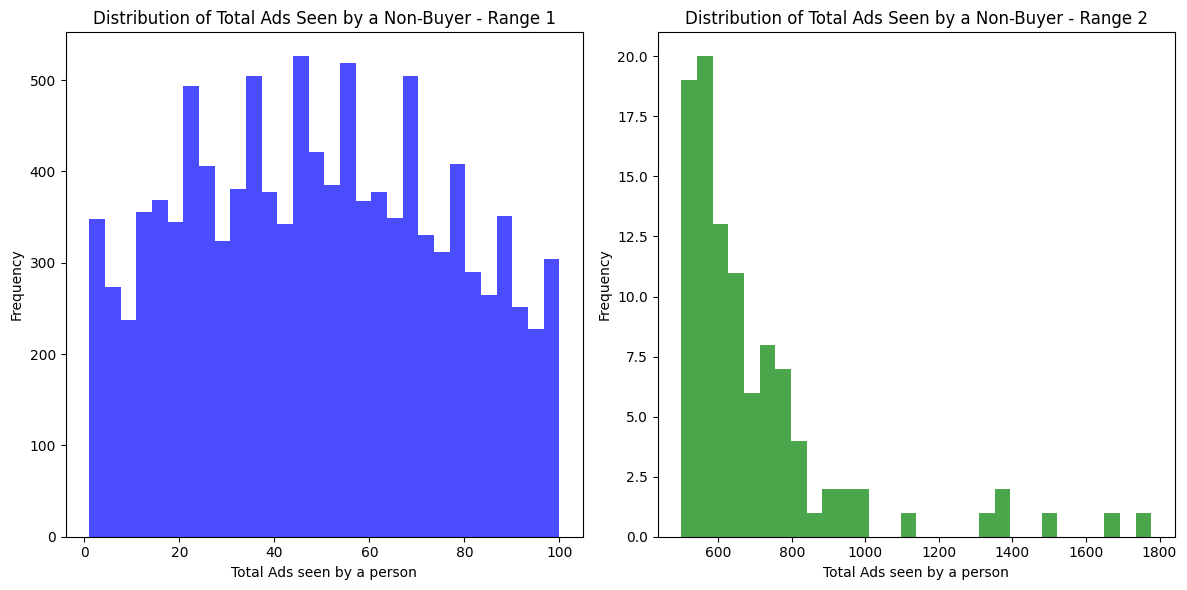

In [20]:
total_ads_not = market.query("converted == True")['total ads']

# Define the two ranges of interest and titles for the subplots
range1 = (0, 100)
range2 = (500, 2000)
title1 = "Distribution of Total Ads Seen by a Non-Buyer - Range 1"
title2 = "Distribution of Total Ads Seen by a Non-Buyer - Range 2"
# Call the function to plot the histograms
plot_histograms_by_range(total_ads_not, range1, range2, title1, title2)

From the plots above, it can be seen that majority of the people that didn't buyer a product saw the ads less than 40 times.

 **Could this mean that the number of times an ad is seen affects the no of people that will buy a product?**

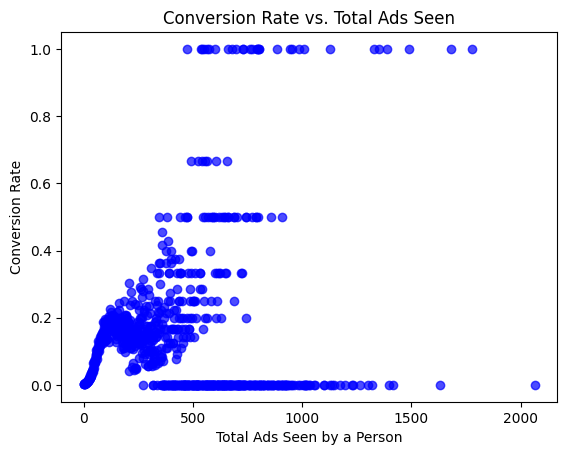

In [21]:
# Calculate the conversion rate for each total ads count, that is the percentage of people that saw the ad and bought a product for each total ads count
conversion_rate = market.groupby('total ads')['converted'].mean()

# Create a scatter plot
plt.scatter(conversion_rate.index, conversion_rate.values, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Total Ads Seen by a Person')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate vs. Total Ads Seen')

# Show the plot
plt.show()

The corr() method is used to calculate the correlation between two numeric variables, but in this case, i want to calculate the correlation between the 'total ads' and the 'conversion rate', which are two Series with different lengths.

To calculate the correlation coefficient between these two variables, i will use the pearsonr() function from the scipy.stats module.

In [27]:
# Calculate the correlation coefficient
corr_coeff, p_value = stats.pearsonr(conversion_rate.index, conversion_rate.values)
print("Correlation Coefficient:", corr_coeff)

Correlation Coefficient: 0.13412564543783353


From the plot and the correlation coefficient above, the correlation is positive, which means that as the 'Total Ads Seen by a Person' increases, the 'Conversion Rate' also tends to increase. However, the correlation coefficient value is relatively close to 0 (weak correlation), suggesting that the relationship is not very strong. It is considered weak because the absolute value of the correlation coefficient is less than 0.3.

**So therefore the number of ads seen by a person doesn't exactly determine if the person will buy a product.**

## Were the Ads successful?

In [23]:
# Compute the conversion rates for each group
conversion_rates = market.groupby('test group')['converted'].mean()

# Print the results
print("Conversion Rates:\n----------------------------------------")
print(conversion_rates )

Conversion Rates:
----------------------------------------
test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


## A/B Test

Hypotheses:

Null Hypothesis (H0): There is no significant difference in purchase rates between the control and experimental groups.

Alternative Hypothesis (H1): There is a significant difference in purchase rates between the control and experimental groups.

## Is the difference between the two groups staticially relevant

## Chi test

In [24]:
from scipy.stats import chi2_contingency
# Perform a chi-squared test to check for statistical significance
contingency_table = pd.crosstab(market['test group'], market['converted'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Determine if the A/B test is statistically significant (alpha = 0.05)
alpha = 0.05
is_significant = p < alpha

# Print the results
print("\nChi-squared test:")
print(f"Chi2 value: {chi2}")
print(f"P-value: {p}")
print('\nPurchase Rate Difference')
print('-----------------------------------')
# Check if the p-value is less than alpha
if p < alpha:
    print("Reject the null hypothesis: There is a significant difference in purchase rates.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in purchase rates.")


Chi-squared test:
Chi2 value: 54.005823883685245
P-value: 1.9989623063390075e-13

Purchase Rate Difference
-----------------------------------
Reject the null hypothesis: There is a significant difference in purchase rates.


## T-test

In [25]:
# Separate data into control and experimental groups
control_data = market[market['test group'] == 'psa']['converted']
experimental_data = market[market['test group'] == 'ad']['converted']

# Calculate conversion rates for each group
conversion_rate_control = control_data.mean()
conversion_rate_experimental = experimental_data.mean()

# Perform a two-sample independent t-test
t_stat, p_value = ttest_ind(control_data, experimental_data, alternative='two-sided')

# Determine statistical significance (alpha = 0.05)
alpha = 0.05
is_significant = p_value < alpha

print("\nT-test Results\n------------------------------")
print("T-statistic:", t_stat)
print("P-value:", p_value)
print('\nPurchase Rate Diference')
print('-------------------------------')
# Check if the p-value is less than alpha
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in purchase rates.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in purchase rates.")


T-test Results
------------------------------
T-statistic: -7.37040597428566
P-value: 1.7033052627831264e-13

Purchase Rate Diference
-------------------------------
Reject the null hypothesis: There is a significant difference in purchase rates.
